# Intro

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Links

Canvas: https://canvas.northwestern.edu/courses/167719/assignments/1078610?module_item_id=2319284




Kaggle: https://www.kaggle.com/competitions/nlp-getting-started/overview

## Modules

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

#Library for LSTM Model
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers



#Library for evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings("ignore")

## Import Data

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [ ]:
%%capture
!kaggle competitions download -c nlp-getting-started

In [ ]:
!unzip 'nlp-getting-started.zip'

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#EDA

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [ ]:
train[train["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

In [ ]:
train[train["target"] == 0]["text"].values[1]

'I love fruits'

In [ ]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

Text(0.5, 1.0, 'Target Distributions \n (0: Non Disaster || 1: Disaster)')

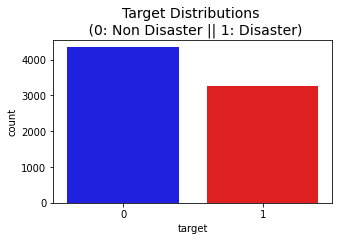

In [ ]:
# plot target counts
plt.figure(figsize=(5,3))
colors = ["blue", "red"]

sns.countplot(x = 'target', data=train, palette=colors)
plt.title('Target Distributions \n (0: Non Disaster || 1: Disaster)', fontsize=14)

In [ ]:
# number of unique keywords
train["keyword"].nunique()

221

Text(0.5, 0, 'Count of Keywords')

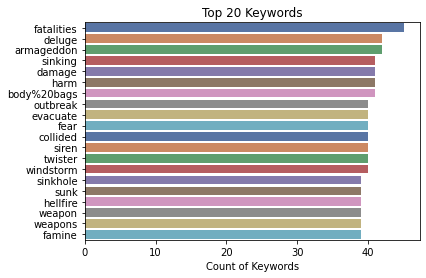

In [ ]:
# plotting top 20 keywords
keywords_20=train['keyword'].value_counts()[:20]
sns.barplot(x=keywords_20, y=keywords_20.index,palette='deep')
plt.title("Top 20 Keywords")
plt.xlabel("Count of Keywords")

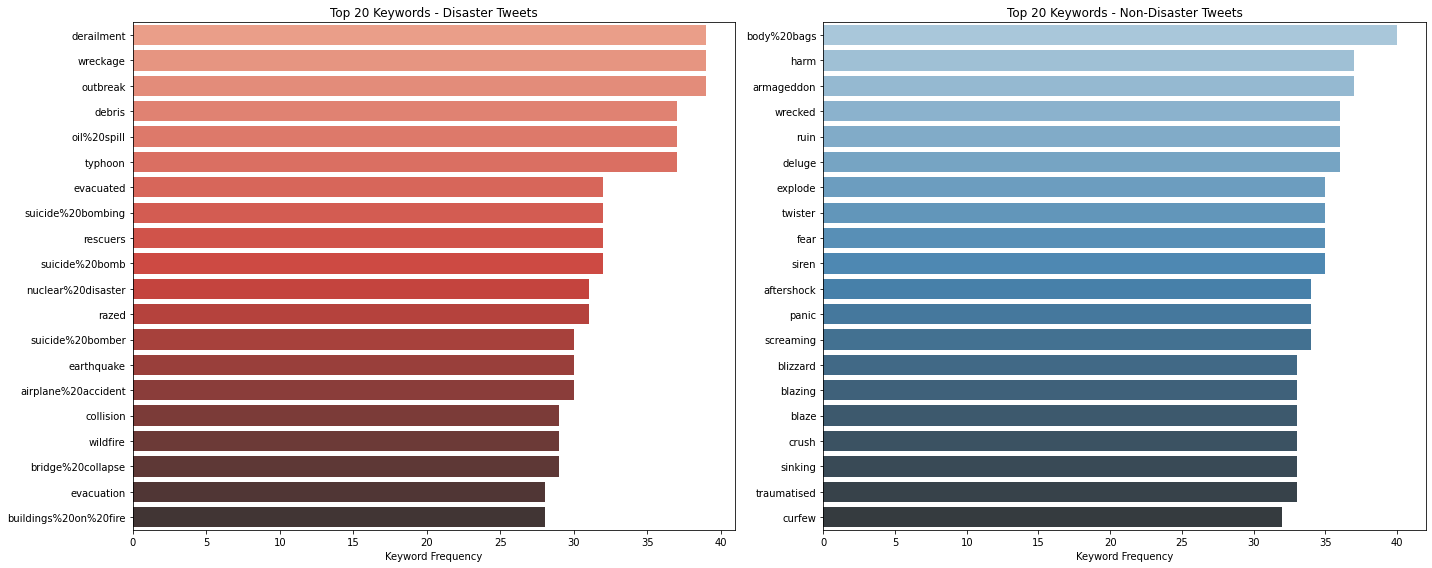

In [ ]:
# plotting top 20 disaster and non disaster keywords
disaster_keywords = train.loc[train["target"] == 1]["keyword"].value_counts()
nondisaster_keywords = train.loc[train["target"] == 0]["keyword"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=disaster_keywords[0:20].index, x=disaster_keywords[0:20], orient='h', ax=ax[0], palette="Reds_d")
ax[0].set_title("Top 20 Keywords - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")

sns.barplot(y=nondisaster_keywords[0:20].index, x=nondisaster_keywords[0:20], orient='h', ax=ax[1], palette="Blues_d")
ax[1].set_title("Top 20 Keywords - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")


plt.tight_layout()
plt.show()

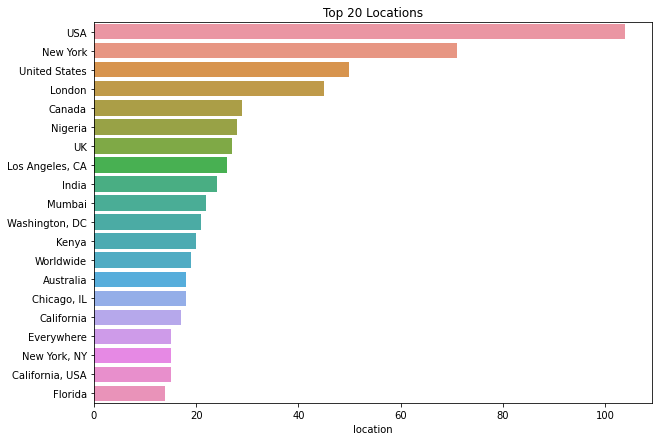

In [ ]:
locations = train["location"].value_counts()

plt.figure(figsize=(10,7))


sns.barplot(y=locations[0:20].index, x=locations[0:20], orient='h')

plt.title("Top 20 Locations")
plt.show()

In [ ]:
# add text length to dataframe
train["length"]  = train["text"].apply(len)
train.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [ ]:
train['length'].describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

In [ ]:
# checking longest tweet
train[train['length']==157]['text'].iloc[0]

"when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????"

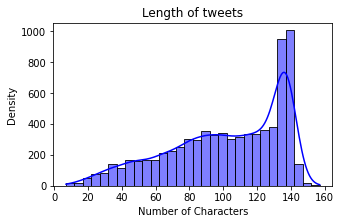

In [ ]:
# plot histogram of tweet lengths
plt.figure(figsize=(5,3))
sns.histplot(train["length"], kde=True,color='blue',bins=30)
plt.title("Length of tweets")
plt.xlabel("Number of Characters")
plt.ylabel("Density")
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f681ef82410>,
      dtype=object)

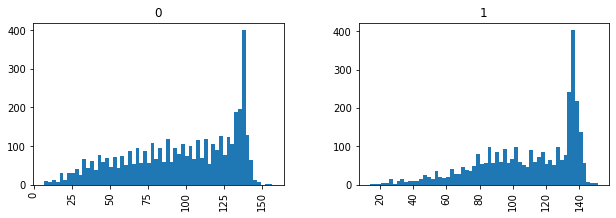

In [ ]:
# plot histogram of tweet lengths by target
train.hist(column='length', by = 'target',bins =60, figsize= (10,3))

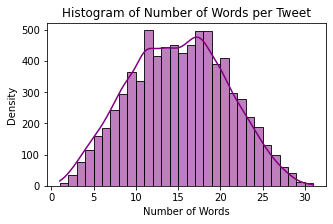

In [ ]:
# plot histogram of number of words per tweet
def count_words(x):
    return len(x.split())

train["num_words"] = train["text"].apply(count_words)

plt.figure(figsize=(5,3))
sns.histplot(train["num_words"],kde=True,color='purple',bins=30)
plt.title("Histogram of Number of Words per Tweet")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f681ecd52d0>,
      dtype=object)

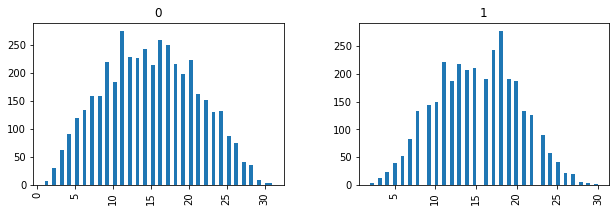

In [ ]:
# plot histogram of number of words per tweet by target
train.hist(column='num_words', by = 'target',bins =60, figsize= (10,3))

In [ ]:
train['num_words'].describe()

count    7613.000000
mean       14.903586
std         5.732604
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: num_words, dtype: float64

# Data Processing

## Remove Punctuation

In [ ]:
# punctuation to be removed
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# function to remove punctuations in a text
def toclean_text(text):


    clean_text = [char for char in text if char not in string.punctuation]

    clean_text = ''.join(clean_text)


    return clean_text

In [ ]:
# apply it to training data and create a column clean_text for the training data
train['clean_text'] = train['text'].apply(toclean_text)

## Remove Noise

In [ ]:
# create dictionary for abbreviations
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [ ]:
# Remove all URLs, replace by URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

# Remove HTML beacon
def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# Change an abbreviation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "
    return string

# Remove @ and mention, replace by USER
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)

# Remove numbers, replace it by NUMBER
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

# Remove all emojis, replace by EMOJI
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text)

# Replace some others smileys with SADFACE
def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

# Replace some smileys with SMILE
def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'SMILE', text)

# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

In [ ]:
def clean_tweet(text):

    # Remove non text
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)

    # replace abbreviations, @ and number
    text = replace_abbrev(text)
    text = remove_mention(text)
    text = remove_number(text)

    # Remove emojis / smileys
    text = remove_emoji(text)
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)

    return text

In [ ]:
# clean text data
train['clean_text'] = train['clean_text'].apply(clean_tweet)

In [ ]:
train.head()

,id,keyword,location,text,target,length,num_words,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,All residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,NUMBER people receive wildfires evacuation ord...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,Just got sent this photo from Ruby Alaska as s...


## Tokenization

In [ ]:
# create tokenizer to encode the texts to numerical values
max_features=5000
max_l=50

tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train['clean_text'].values)
X = tokenizer.texts_to_sequences(train['clean_text'].values)
X = pad_sequences(X, maxlen=max_l)

In [ ]:
X.shape

(7613, 50)

## Train/Test Split

In [ ]:
y = train['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Design and Training

In [ ]:
# activate tensorflow XLA compiler for accelerated modeling speed and imrpoved memory usage
import os

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [ ]:
# early stopping
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

## LSTM Model 1

In [ ]:
# define hyperparameters
batch_size = 32
epochs = 10
embed_dim = 128
lstm_out = 128

In [ ]:
# build LSTM model
model1 = Sequential()
model1.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model1.add(Dropout(0.2))
model1.add(LSTM(lstm_out, dropout=0.2, return_sequences=True, recurrent_dropout=0.4))
model1.add(Dropout(0.2))
model1.add(LSTM(lstm_out,dropout=0.2, recurrent_dropout=0.2))
model1.add(Dropout(0.2))
model1.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=2e-3)
model1.compile(loss = 'binary_crossentropy', optimizer=adam, metrics = ['accuracy'])
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           640000    
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 lstm (LSTM)                 (None, 50, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [ ]:
model1.fit(X_train, y_train,
           epochs = epochs,
           batch_size=batch_size,
           validation_data=(X_test, y_test),
           callbacks=es_callback)

Epoch 1/10
191/191 [==============================] - 101s 490ms/step - loss: 0.5295 - accuracy: 0.7289 - val_loss: 0.4441 - val_accuracy: 0.8089
Epoch 2/10
191/191 [==============================] - 81s 423ms/step - loss: 0.3647 - accuracy: 0.8483 - val_loss: 0.4738 - val_accuracy: 0.8017
Epoch 3/10
191/191 [==============================] - 78s 410ms/step - loss: 0.2822 - accuracy: 0.8892 - val_loss: 0.5165 - val_accuracy: 0.7768
Epoch 4/10
191/191 [==============================] - 80s 417ms/step - loss: 0.2140 - accuracy: 0.9156 - val_loss: 0.6370 - val_accuracy: 0.7768


In [ ]:
train_scores = model1.evaluate(X_train, y_train, batch_size=batch_size)
loss, acc = model1.evaluate(X_test, y_test, batch_size=batch_size)
print('Test loss:', loss)
print('Test accuracy:', acc)

48/48 [==============================] - 1s 29ms/step - loss: 0.6370 - accuracy: 0.7768
Test loss: 0.6370363235473633
Test accuracy: 0.7767564058303833


In [ ]:
results = pd.DataFrame(columns = ['Model', 'Units', 'Batch Size', 'Epochs', 'Training Loss', 'Training Accuracy', 'Testing Loss', 'Testing Accuracy'])

#eval
Model = 'LSTM Model 1'
LSTM_Units = lstm_out
Batch_Size = batch_size
Epochs = epochs
Training_Loss = train_scores[0]
Training_Accuracy = train_scores[1]
Test_Loss = loss
Test_Accuracy = acc
row = [Model, LSTM_Units, Batch_Size, Epochs, Training_Loss, Training_Accuracy, Test_Loss, Test_Accuracy]
results = results.append(pd.DataFrame([row], columns=results.columns), ignore_index=True)
results

,Model,Units,Batch Size,Epochs,Training Loss,Training Accuracy,Testing Loss,Testing Accuracy
0,LSTM Model 1,128,32,10,0.13017,0.953859,0.637036,0.776756


## LSTM Model 2

In [ ]:
# define hyperparameters
batch_size = 32
epochs = 10
embed_dim = 256
lstm_out = 256

In [ ]:
# build LSTM model
model2 = Sequential()
model2.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model2.add(Dropout(0.2))
model2.add(LSTM(lstm_out, dropout=0.2, return_sequences=True, recurrent_dropout=0.4))
model2.add(Dropout(0.2))
model2.add(LSTM(lstm_out,dropout=0.2, recurrent_dropout=0.2))
model2.add(Dropout(0.2))
model2.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=2e-3)
model2.compile(loss = 'binary_crossentropy', optimizer=adam, metrics = ['accuracy'])
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 256)           1280000   
                                                                 
 dropout_3 (Dropout)         (None, 50, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 256)           525312    
                                                                 
 dropout_4 (Dropout)         (None, 50, 256)           0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [ ]:
model2.fit(X_train, y_train,
           epochs = epochs,
           batch_size=batch_size,
           validation_data=(X_test, y_test),
           callbacks=es_callback)

Epoch 1/10
191/191 [==============================] - 98s 493ms/step - loss: 0.5067 - accuracy: 0.7555 - val_loss: 0.4539 - val_accuracy: 0.7945
Epoch 2/10
191/191 [==============================] - 93s 487ms/step - loss: 0.3545 - accuracy: 0.8539 - val_loss: 0.4557 - val_accuracy: 0.7997
Epoch 3/10
191/191 [==============================] - 92s 483ms/step - loss: 0.2679 - accuracy: 0.8947 - val_loss: 0.5523 - val_accuracy: 0.7663
Epoch 4/10
191/191 [==============================] - 93s 487ms/step - loss: 0.1933 - accuracy: 0.9258 - val_loss: 0.6707 - val_accuracy: 0.7466


In [ ]:
train_scores = model2.evaluate(X_train, y_train, batch_size=batch_size)
loss, acc = model2.evaluate(X_test, y_test, batch_size=batch_size)
print('Test loss:', loss)
print('Test accuracy:', acc)

48/48 [==============================] - 2s 38ms/step - loss: 0.6707 - accuracy: 0.7466
Test loss: 0.6707230806350708
Test accuracy: 0.7465528845787048


In [ ]:
#eval
Model = 'LSTM Model 2'
LSTM_Units = lstm_out
Batch_Size = batch_size
Epochs = epochs
Training_Loss = train_scores[0]
Training_Accuracy = train_scores[1]
Test_Loss = loss
Test_Accuracy = acc
row = [Model, LSTM_Units, Batch_Size, Epochs, Training_Loss, Training_Accuracy, Test_Loss, Test_Accuracy]
results = results.append(pd.DataFrame([row], columns=results.columns), ignore_index=True)
results

,Model,Units,Batch Size,Epochs,Training Loss,Training Accuracy,Testing Loss,Testing Accuracy
0,LSTM Model 1,128,32,10,0.130170,0.953859,0.637036,0.776756
1,LSTM Model 2,256,32,10,0.136804,0.953038,0.670723,0.746553


## LSTM Model 3

In [ ]:
# define hyperparameters
batch_size = 32
epochs = 10
embed_dim = 512
lstm_out = 512

In [ ]:
# build LSTM model
model3 = Sequential()
model3.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model3.add(Dropout(0.2))
model3.add(LSTM(lstm_out, dropout=0.2, return_sequences=True, recurrent_dropout=0.4))
model3.add(Dropout(0.2))
model3.add(LSTM(lstm_out,dropout=0.2, recurrent_dropout=0.2))
model3.add(Dropout(0.2))
model3.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=2e-3)
model3.compile(loss = 'binary_crossentropy', optimizer=adam, metrics = ['accuracy'])
print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 512)           2560000   
                                                                 
 dropout_6 (Dropout)         (None, 50, 512)           0         
                                                                 
 lstm_4 (LSTM)               (None, 50, 512)           2099200   
                                                                 
 dropout_7 (Dropout)         (None, 50, 512)           0         
                                                                 
 lstm_5 (LSTM)               (None, 512)               2099200   
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [ ]:
model3.fit(X_train, y_train,
           epochs = epochs,
           batch_size=batch_size,
           validation_data=(X_test, y_test),
           callbacks=es_callback)

Epoch 1/10
191/191 [==============================] - 101s 507ms/step - loss: 0.5221 - accuracy: 0.7524 - val_loss: 0.4566 - val_accuracy: 0.8030
Epoch 2/10
191/191 [==============================] - 96s 503ms/step - loss: 0.3581 - accuracy: 0.8568 - val_loss: 0.5579 - val_accuracy: 0.7991
Epoch 3/10
191/191 [==============================] - 95s 497ms/step - loss: 0.2671 - accuracy: 0.8998 - val_loss: 0.5932 - val_accuracy: 0.7689
Epoch 4/10
191/191 [==============================] - 100s 524ms/step - loss: 0.1866 - accuracy: 0.9266 - val_loss: 0.6795 - val_accuracy: 0.7663


In [ ]:
train_scores = model3.evaluate(X_train, y_train, batch_size=batch_size)
loss, acc = model3.evaluate(X_test, y_test, batch_size=batch_size)
print('Test loss:', loss)
print('Test accuracy:', acc)

48/48 [==============================] - 2s 44ms/step - loss: 0.6795 - accuracy: 0.7663
Test loss: 0.6794980764389038
Test accuracy: 0.7662508487701416


In [ ]:
#eval
Model = 'LSTM Model 3'
LSTM_Units = lstm_out
Batch_Size = batch_size
Epochs = epochs
Training_Loss = train_scores[0]
Training_Accuracy = train_scores[1]
Test_Loss = loss
Test_Accuracy = acc
row = [Model, LSTM_Units, Batch_Size, Epochs, Training_Loss, Training_Accuracy, Test_Loss, Test_Accuracy]
results = results.append(pd.DataFrame([row], columns=results.columns), ignore_index=True)
results

,Model,Units,Batch Size,Epochs,Training Loss,Training Accuracy,Testing Loss,Testing Accuracy
0,LSTM Model 1,128,32,10,0.130170,0.953859,0.637036,0.776756
1,LSTM Model 2,256,32,10,0.136804,0.953038,0.670723,0.746553
2,LSTM Model 3,512,32,10,0.116587,0.961248,0.679498,0.766251


## LSTM Model 4

In [ ]:
# define hyperparameters
batch_size = 64
epochs = 10
embed_dim = 128
lstm_out = 128

In [ ]:
# build LSTM model
model4 = Sequential()
model4.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model4.add(Dropout(0.2))
model4.add(LSTM(lstm_out, dropout=0.2, return_sequences=True, recurrent_dropout=0.4))
model4.add(Dropout(0.2))
model4.add(LSTM(lstm_out,dropout=0.2, recurrent_dropout=0.2))
model4.add(Dropout(0.2))
model4.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=2e-3)
model4.compile(loss = 'binary_crossentropy', optimizer=adam, metrics = ['accuracy'])
print(model4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 128)           640000    
                                                                 
 dropout_9 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_6 (LSTM)               (None, 50, 128)           131584    
                                                                 
 dropout_10 (Dropout)        (None, 50, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
model4.fit(X_train, y_train,
           epochs = epochs,
           batch_size=batch_size,
           validation_data=(X_test, y_test),
           callbacks=es_callback)

Epoch 1/10
96/96 [==============================] - 48s 452ms/step - loss: 0.5371 - accuracy: 0.7284 - val_loss: 0.4411 - val_accuracy: 0.8011
Epoch 2/10
96/96 [==============================] - 40s 421ms/step - loss: 0.3564 - accuracy: 0.8501 - val_loss: 0.4635 - val_accuracy: 0.7912
Epoch 3/10
96/96 [==============================] - 40s 412ms/step - loss: 0.2832 - accuracy: 0.8888 - val_loss: 0.5171 - val_accuracy: 0.7669
Epoch 4/10
96/96 [==============================] - 40s 413ms/step - loss: 0.2322 - accuracy: 0.9115 - val_loss: 0.6000 - val_accuracy: 0.7748


In [ ]:
train_scores = model4.evaluate(X_train, y_train, batch_size=batch_size)
loss, acc = model4.evaluate(X_test, y_test, batch_size=batch_size)
print('Test loss:', loss)
print('Test accuracy:', acc)

24/24 [==============================] - 1s 29ms/step - loss: 0.6000 - accuracy: 0.7748
Test loss: 0.6000043153762817
Test accuracy: 0.7747865915298462


In [ ]:
#eval
Model = 'LSTM Model 4'
LSTM_Units = lstm_out
Batch_Size = batch_size
Epochs = epochs
Training_Loss = train_scores[0]
Training_Accuracy = train_scores[1]
Test_Loss = loss
Test_Accuracy = acc
row = [Model, LSTM_Units, Batch_Size, Epochs, Training_Loss, Training_Accuracy, Test_Loss, Test_Accuracy]
results = results.append(pd.DataFrame([row], columns=results.columns), ignore_index=True)
results

,Model,Units,Batch Size,Epochs,Training Loss,Training Accuracy,Testing Loss,Testing Accuracy
0,LSTM Model 1,128,32,10,0.130170,0.953859,0.637036,0.776756
1,LSTM Model 2,256,32,10,0.136804,0.953038,0.670723,0.746553
2,LSTM Model 3,512,32,10,0.116587,0.961248,0.679498,0.766251
3,LSTM Model 4,128,64,10,0.150015,0.950575,0.600004,0.774787


## LSTM Model 5

In [ ]:
# define hyperparameters
batch_size = 64
epochs = 10
embed_dim = 256
lstm_out = 256

In [ ]:
# build LSTM model
model5 = Sequential()
model5.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model5.add(Dropout(0.2))
model5.add(LSTM(lstm_out, dropout=0.2, return_sequences=True, recurrent_dropout=0.4))
model5.add(Dropout(0.2))
model5.add(LSTM(lstm_out,dropout=0.2, recurrent_dropout=0.2))
model5.add(Dropout(0.2))
model5.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=2e-3)
model5.compile(loss = 'binary_crossentropy', optimizer=adam, metrics = ['accuracy'])
print(model5.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 256)           1280000   
                                                                 
 dropout_12 (Dropout)        (None, 50, 256)           0         
                                                                 
 lstm_8 (LSTM)               (None, 50, 256)           525312    
                                                                 
 dropout_13 (Dropout)        (None, 50, 256)           0         
                                                                 
 lstm_9 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [ ]:
model5.fit(X_train, y_train,
           epochs = epochs,
           batch_size=batch_size,
           validation_data=(X_test, y_test),
           callbacks=es_callback)

Epoch 1/10
96/96 [==============================] - 52s 497ms/step - loss: 0.5283 - accuracy: 0.7351 - val_loss: 0.4402 - val_accuracy: 0.8063
Epoch 2/10
96/96 [==============================] - 46s 483ms/step - loss: 0.3510 - accuracy: 0.8529 - val_loss: 0.4938 - val_accuracy: 0.7899
Epoch 3/10
96/96 [==============================] - 47s 492ms/step - loss: 0.2722 - accuracy: 0.8920 - val_loss: 0.6742 - val_accuracy: 0.7814
Epoch 4/10
96/96 [==============================] - 47s 487ms/step - loss: 0.2138 - accuracy: 0.9149 - val_loss: 0.6151 - val_accuracy: 0.7643


In [ ]:
train_scores = model5.evaluate(X_train, y_train, batch_size=batch_size)
loss, acc = model5.evaluate(X_test, y_test, batch_size=batch_size)
print('Test loss:', loss)
print('Test accuracy:', acc)

24/24 [==============================] - 1s 40ms/step - loss: 0.6151 - accuracy: 0.7643
Test loss: 0.6151447296142578
Test accuracy: 0.7642810344696045


In [ ]:
#eval
Model = 'LSTM Model 5'
LSTM_Units = lstm_out
Batch_Size = batch_size
Epochs = epochs
Training_Loss = train_scores[0]
Training_Accuracy = train_scores[1]
Test_Loss = loss
Test_Accuracy = acc
row = [Model, LSTM_Units, Batch_Size, Epochs, Training_Loss, Training_Accuracy, Test_Loss, Test_Accuracy]
results = results.append(pd.DataFrame([row], columns=results.columns), ignore_index=True)
results

,Model,Units,Batch Size,Epochs,Training Loss,Training Accuracy,Testing Loss,Testing Accuracy
0,LSTM Model 1,128,32,10,0.130170,0.953859,0.637036,0.776756
1,LSTM Model 2,256,32,10,0.136804,0.953038,0.670723,0.746553
2,LSTM Model 3,512,32,10,0.116587,0.961248,0.679498,0.766251
3,LSTM Model 4,128,64,10,0.150015,0.950575,0.600004,0.774787
4,LSTM Model 5,256,64,10,0.130680,0.954680,0.615145,0.764281


## LSTM Model 6

In [ ]:
# define hyperparameters
batch_size = 64
epochs = 10
embed_dim = 512
lstm_out = 512

In [ ]:
# build LSTM model
model6 = Sequential()
model6.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model6.add(Dropout(0.2))
model6.add(LSTM(lstm_out, dropout=0.2, return_sequences=True, recurrent_dropout=0.4))
model6.add(Dropout(0.2))
model6.add(LSTM(lstm_out,dropout=0.2, recurrent_dropout=0.2))
model6.add(Dropout(0.2))
model6.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=2e-3)
model6.compile(loss = 'binary_crossentropy', optimizer=adam, metrics = ['accuracy'])
print(model6.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 512)           2560000   
                                                                 
 dropout_15 (Dropout)        (None, 50, 512)           0         
                                                                 
 lstm_10 (LSTM)              (None, 50, 512)           2099200   
                                                                 
 dropout_16 (Dropout)        (None, 50, 512)           0         
                                                                 
 lstm_11 (LSTM)              (None, 512)               2099200   
                                                                 
 dropout_17 (Dropout)        (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [ ]:
model6.fit(X_train, y_train,
           epochs = epochs,
           batch_size=batch_size,
           validation_data=(X_test, y_test),
           callbacks=es_callback)

Epoch 1/10
96/96 [==============================] - 52s 496ms/step - loss: 0.5281 - accuracy: 0.7455 - val_loss: 0.4770 - val_accuracy: 0.7866
Epoch 2/10
96/96 [==============================] - 48s 500ms/step - loss: 0.3578 - accuracy: 0.8542 - val_loss: 0.5001 - val_accuracy: 0.8011
Epoch 3/10
96/96 [==============================] - 47s 490ms/step - loss: 0.2642 - accuracy: 0.8969 - val_loss: 0.5771 - val_accuracy: 0.7689
Epoch 4/10
96/96 [==============================] - 48s 499ms/step - loss: 0.1909 - accuracy: 0.9291 - val_loss: 0.6348 - val_accuracy: 0.7623


In [ ]:
train_scores = model6.evaluate(X_train, y_train, batch_size=batch_size)
loss, acc = model6.evaluate(X_test, y_test, batch_size=batch_size)
print('Test loss:', loss)
print('Test accuracy:', acc)

24/24 [==============================] - 1s 45ms/step - loss: 0.6348 - accuracy: 0.7623
Test loss: 0.6347910761833191
Test accuracy: 0.7623112201690674


In [ ]:
#eval
Model = 'LSTM Model 6'
LSTM_Units = lstm_out
Batch_Size = batch_size
Epochs = epochs
Training_Loss = train_scores[0]
Training_Accuracy = train_scores[1]
Test_Loss = loss
Test_Accuracy = acc
row = [Model, LSTM_Units, Batch_Size, Epochs, Training_Loss, Training_Accuracy, Test_Loss, Test_Accuracy]
results = results.append(pd.DataFrame([row], columns=results.columns), ignore_index=True)
results

,Model,Units,Batch Size,Epochs,Training Loss,Training Accuracy,Testing Loss,Testing Accuracy
0,LSTM Model 1,128,32,10,0.130170,0.953859,0.637036,0.776756
1,LSTM Model 2,256,32,10,0.136804,0.953038,0.670723,0.746553
2,LSTM Model 3,512,32,10,0.116587,0.961248,0.679498,0.766251
3,LSTM Model 4,128,64,10,0.150015,0.950575,0.600004,0.774787
4,LSTM Model 5,256,64,10,0.130680,0.954680,0.615145,0.764281
5,LSTM Model 6,512,64,10,0.127265,0.960263,0.634791,0.762311


## BERT Model

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts:
        text = tokenizer.tokenize(text)

        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)

        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len

        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 23.4 s, sys: 4.28 s, total: 27.6 s
Wall time: 30.3 s


In [ ]:
!pip install bert-tensorflow
from bert import tokenization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 3.3 MB/s 


In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts:
        text = tokenizer.tokenize(text)

        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)

        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len

        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 16.8 s, sys: 2.07 s, total: 18.9 s
Wall time: 23.5 s


In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
import sys
from absl import flags
sys.argv=['preserve_unused_tokens=False']
flags.FLAGS(sys.argv)

['preserve_unused_tokens=False']

In [ ]:
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train.target.values

In [ ]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 160)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 160)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 160)]        0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     [(None, 1024),       335141889   ['input_word_ids[0][0]',         
                                 (None, 160, 1024)]               'input_mask[0][0]',         

In [ ]:
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    batch_size=16
)

model.save('model.h5')

Epoch 1/3
381/381 [==============================] - 716s 2s/step - loss: 0.4687 - accuracy: 0.7926 - val_loss: 0.3902 - val_accuracy: 0.8326
Epoch 2/3
381/381 [==============================] - 675s 2s/step - loss: 0.3308 - accuracy: 0.8637 - val_loss: 0.4049 - val_accuracy: 0.8319
Epoch 3/3
381/381 [==============================] - 674s 2s/step - loss: 0.2630 - accuracy: 0.8920 - val_loss: 0.4170 - val_accuracy: 0.8286


# Model Evaluation

## LSTM Model 1

In [ ]:
y_pred = model1.predict(X_test).round()

In [ ]:
y_pred

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
print('Accuracy:', (metrics.accuracy_score(y_test, y_pred)))
print('Recall:', (metrics.recall_score(y_test, y_pred)))
print('Precision:', (metrics.precision_score(y_test, y_pred)))

Accuracy: 0.7767564018384767
Recall: 0.7010785824345146
Precision: 0.757071547420965


In [ ]:
con_mat = confusion_matrix(y_test,y_pred)
con_mat

array([[728, 146],
       [194, 455]])

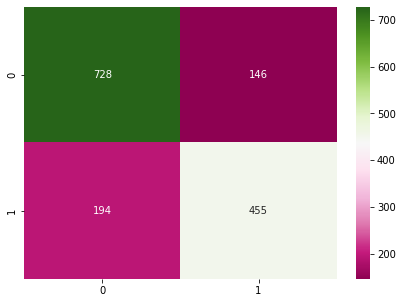

In [ ]:
plt.figure(figsize=(7, 5))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='PiYG')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       874
           1       0.76      0.70      0.73       649

    accuracy                           0.78      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



## LSTM Model 2

In [ ]:
y_pred = model2.predict(X_test).round()

In [ ]:
y_pred

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
print('Accuracy:', (metrics.accuracy_score(y_test, y_pred)))
print('Recall:', (metrics.recall_score(y_test, y_pred)))
print('Precision:', (metrics.precision_score(y_test, y_pred)))

Accuracy: 0.7465528562048588
Recall: 0.6702619414483821
Precision: 0.7166392092257001


In [ ]:
con_mat = confusion_matrix(y_test,y_pred)
con_mat

array([[702, 172],
       [214, 435]])

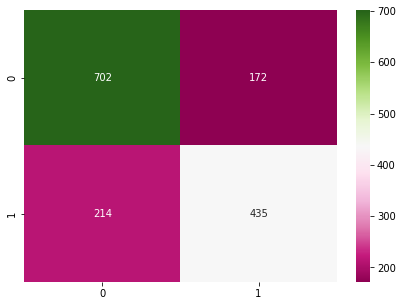

In [ ]:
plt.figure(figsize=(7, 5))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='PiYG')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.80      0.78       874
           1       0.72      0.67      0.69       649

    accuracy                           0.75      1523
   macro avg       0.74      0.74      0.74      1523
weighted avg       0.75      0.75      0.75      1523



## LSTM Model 3

In [ ]:
y_pred = model3.predict(X_test).round()

In [ ]:
y_pred

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
print('Accuracy:', (metrics.accuracy_score(y_test, y_pred)))
print('Recall:', (metrics.recall_score(y_test, y_pred)))
print('Precision:', (metrics.precision_score(y_test, y_pred)))

Accuracy: 0.7662508207485227
Recall: 0.7180277349768875
Precision: 0.729264475743349


In [ ]:
con_mat = confusion_matrix(y_test,y_pred)
con_mat

array([[701, 173],
       [183, 466]])

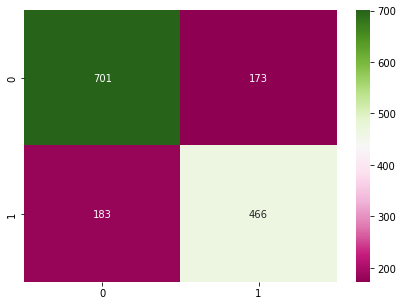

In [ ]:
plt.figure(figsize=(7, 5))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='PiYG')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.80      0.80       874
           1       0.73      0.72      0.72       649

    accuracy                           0.77      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523



## LSTM Model 4

In [ ]:
y_pred = model4.predict(X_test).round()

In [ ]:
y_pred

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
print('Accuracy:', (metrics.accuracy_score(y_test, y_pred)))
print('Recall:', (metrics.recall_score(y_test, y_pred)))
print('Precision:', (metrics.precision_score(y_test, y_pred)))

Accuracy: 0.7747866053841103
Recall: 0.7226502311248074
Precision: 0.7420886075949367


In [ ]:
con_mat = confusion_matrix(y_test,y_pred)
con_mat

array([[711, 163],
       [180, 469]])

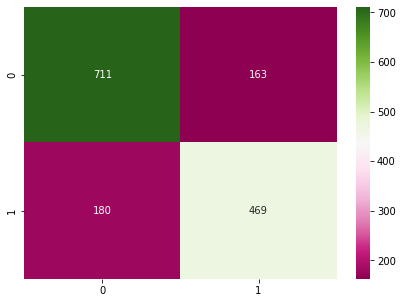

In [ ]:
plt.figure(figsize=(7, 5))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='PiYG')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.81      0.81       874
           1       0.74      0.72      0.73       649

    accuracy                           0.77      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.77      0.77      0.77      1523



## LSTM Model 5

In [ ]:
y_pred = model5.predict(X_test).round()

In [ ]:
y_pred

array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
print('Accuracy:', (metrics.accuracy_score(y_test, y_pred)))
print('Recall:', (metrics.recall_score(y_test, y_pred)))
print('Precision:', (metrics.precision_score(y_test, y_pred)))

Accuracy: 0.7642810242941562
Recall: 0.7010785824345146
Precision: 0.7338709677419355


In [ ]:
con_mat = confusion_matrix(y_test,y_pred)
con_mat

array([[709, 165],
       [194, 455]])

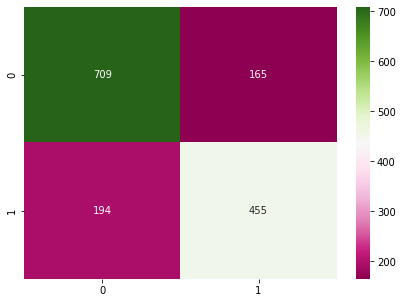

In [ ]:
plt.figure(figsize=(7, 5))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='PiYG')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       874
           1       0.73      0.70      0.72       649

    accuracy                           0.76      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.76      0.76      0.76      1523



## LSTM Model 6

In [ ]:
y_pred = model6.predict(X_test).round()

In [ ]:
y_pred

array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
print('Accuracy:', (metrics.accuracy_score(y_test, y_pred)))
print('Recall:', (metrics.recall_score(y_test, y_pred)))
print('Precision:', (metrics.precision_score(y_test, y_pred)))

Accuracy: 0.7623112278397899
Recall: 0.7026194144838213
Precision: 0.7296


In [ ]:
con_mat = confusion_matrix(y_test,y_pred)
con_mat

array([[705, 169],
       [193, 456]])

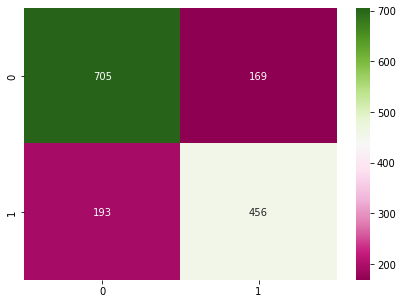

In [ ]:
plt.figure(figsize=(7, 5))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='PiYG')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       874
           1       0.73      0.70      0.72       649

    accuracy                           0.76      1523
   macro avg       0.76      0.75      0.76      1523
weighted avg       0.76      0.76      0.76      1523



# Test Data Predictions for Kaggle Submission

## Data Preprocessing

In [ ]:
test['clean_text'] = test['text'].apply(toclean_text)
test["clean_text"] = test["clean_text"].apply(clean_tweet)

In [ ]:
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train['clean_text'].values)
test_token = tokenizer.texts_to_sequences(test['clean_text'].values)
test_token = pad_sequences(test_token, maxlen=max_l)

In [ ]:
#train best performing LSTM model on whole training dataset
model1.fit(X,y, epochs = 10, validation_split = 0.2, callbacks=[es_callback], batch_size=32)

Epoch 1/10
191/191 [==============================] - 131s 686ms/step - loss: 0.2592 - accuracy: 0.9021 - val_loss: 0.2430 - val_accuracy: 0.9146
Epoch 2/10
191/191 [==============================] - 121s 635ms/step - loss: 0.1840 - accuracy: 0.9312 - val_loss: 0.2732 - val_accuracy: 0.8949
Epoch 3/10
191/191 [==============================] - 114s 598ms/step - loss: 0.1372 - accuracy: 0.9448 - val_loss: 0.3374 - val_accuracy: 0.8877
Epoch 4/10
191/191 [==============================] - 121s 633ms/step - loss: 0.1109 - accuracy: 0.9540 - val_loss: 0.3825 - val_accuracy: 0.8812


## Test Predictions

### LSTM

In [ ]:
y_pred_test = model1.predict(test_token).round()

In [ ]:
submission1 = submission

In [ ]:
submission1['target'] = np.round(y_pred_test).astype('int')
submission1.to_csv('submission1.csv', index=False)

In [ ]:
submission1.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


### BERT

In [ ]:
test_pred = model.predict(test_input)

In [ ]:
submission2 = submission

In [ ]:
submission2['target'] = test_pred.round().astype(int)
submission2.to_csv('submission.csv', index=False)

In [ ]:
submission2.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
%%shell
jupyter nbconvert --to html /content/Module_9_Assignment_1.ipynb


[NbConvertApp] Converting notebook /content/Module_9_Assignment_1.ipynb to html
[NbConvertApp] Writing 780468 bytes to /content/Module_9_Assignment_1.html
